# Notebook for computing Lyapunov Spectrum of the Lorenz 63 system

In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Function to ensure QR decomposition has positive diagonals

def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

### Time Parameters

In [27]:
dt = 1.e-2 # Time step for numerical integration, this is also the interval TLE is solved over
tao = 20 # How many steps TLE pushes you forward
k1 = int(1.e3)
transient = int(k1 * tao) # Number of transient steps
k2 = int(3.e3) # Number of places we calculate FTBLEs
tav = int(k2 * tao) # Number of averaging steps
steps = transient + tav # total number of steps
print(f'Total time we are solving L63 for is {steps * dt}\nSampling FTBLES at {k2} steps.')

Total time we are solving L63 for is 800.0
Sampling FTBLES at 3000 steps.


## Solving and Plotting Lorenz 63

In [28]:
# L63 Definition

#Parameters
a = 10.0
b = 8/3
c = 28.0
p = [a, b, c]

def L63(state, t, p):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    [a, b, c] = p
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt

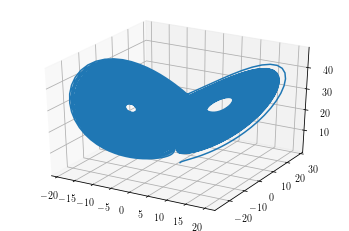

In [52]:
# Solving L63 Numerically using odeint

IC = np.array([1.01, 0.5, 0.01])
time = np.arange(0, steps * dt, dt)
solution = odeint(L63, IC, time, (p,))

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
plt.show()

## Function for Jacobians

We will only need the jacobians after the transient period.

In [53]:
# Function to calucate Jacobian of L63 at a point on trajectory

def Jacobian(location, parameters):
    """Returns the jacobian matrix at a given point of L63.
    Param, location, array: [x, y, z] coordinates.
    Parameters, parameters, L63 parameters.
    """
    [a, b, c] = parameters
    [x, y, z] = location
    row1 = np.array([-a, a, 0])
    row2 = np.array([c - z, -1, -x])
    row3 = np.array([y, x, -b])
    J = np.array([row1, row2, row3])
    return J

# Test of Jacobian Function
# location = [2, 0, 1]
# print(Jacobian(location, [a, b, c]))

In [54]:
# Storing time series of Jacobians
# Note that J(step * dt) = Jacobians[:, :, step]

# jacobians = np.zeros((3, 3, L)) # Time series of Jacobian matrix after transient. 
# for t in range(L): #Indexed as (row, column, transient + step)
# #     print(f'Solution to Lorenz at step {t} (time {time[t]}) is\n {solution[t]}\n\n')
# #     print(f'Jacobian at step {t} (time {time[t]}) is\n{Jacobian(solution[t], [a, b, c])}\n\n')
#     jacobians[:, :, t] = Jacobian(solution[transient + t], [a, b, c])
#     #jacobians[:, :, t] = np.array([[1, -2, 0], [0, -1, 0], [0, 2, -3]]) # Test with constant Jacobian
# #     print(f'Stored Jacobian is\n{jacobians[:, :, t]}\n\n')

## Solving the Tangent Linear Equations

At each point along trajectory of L63 we define a TLE. We solve this numerically with Q_k as the IC. The solution our numerical integration gives is P_k = Q_k R_k. Never need the propagator!

#### First we define eveything we need for the TLEs

In [55]:
# RHS
def TLE(delta, time, p, state):
    """Defines RHS of the TLE at a given point on attractor.
    Param, delta, perturbation evolution being solved for.
    Param, time.
    Param, p, parameters of Lorenz system.
    Param, state, where we are on the attractor.
    """
    J = Jacobian(state, p)
    f = np.dot(J, delta)
    return f

# Time steps for TLE numerical integration
tau = 3 * dt
precision = 1.e-3
TLEtime = np.arange(0, tau, tau * precision) # Note tle is solved on interval [0, dt]

#### Function that solves TLE

In [56]:
def solveTLE(state, oldQ, time):
    """ Solves tangent linear equation.
    Param, state, array: where we are on the attractor, used to define TLE.
    Param, oldQ, IC of TLE being solved. 
    Param, time, timesteps we solve TLE for.
    """
    TLEsolution0 = odeint(TLE, oldQ[:, 0], time, (p, state)) # Solving the TLE for different IC
    col1 = TLEsolution0[-1]
    TLEsolution1 = odeint(TLE, oldQ[:, 1], time, (p, state))
    col2 = TLEsolution1[-1]
    TLEsolution2 = odeint(TLE, oldQ[:, 2], time, (p, state))
    col3 = TLEsolution2[-1]
    Pk = np.column_stack((col1, col2, col3))
    return Pk


## Benettin Algorithm for calculating the Lyapunov Spectrum

In [57]:
# Initialising an orthogonal matrix
eps = 0.1
oldQ = eps * np.identity(3)

In [58]:
FTLE = np.zeros((k2, 3)) # To store time series of FTLES
LE = np.zeros((k2, 3)) # Storing running mean of FTLEs
Pk = np.identity(3)

In [65]:
h=0
for i in np.arange(0, steps, tao):
    
    for j in range(tao):
        h = h + 1
        #print(f'h is {h}\n')
        state = solution[i + j]
        #time = np.linspace(i * dt, (i + 1) * dt, tao, endpoint=False)
        time = np.array([(i + j) * dt, (i + j + 1) * dt])
        Pk = solveTLE(state, oldQ, time)
        oldQ = Pk
    
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonal

    if (i > (transient - 1)): # Store after transient
        k = i - transient      
        ftle = np.log(np.diag(R))/(tao * dt) # Note division by k * dt is done here
        FTLE[int(k/tao)] = ftle
        LE[int(k/tao)] = np.mean(FTLE[0:int(k/tao) + 1], axis = 0)

## SAVED RUN

Saved Run for parameters below. Saves you having to re-run code if you just want to play with statistics/plots.

In [60]:
# dt = 5.e-4 # Time step for numerical integration, this is also the interval TLE is solved over
# transient = int(1.e2) # Number of transient steps
# L = int(4.e5) # Steps we will sample on attractor
# eps = 1.e-7

# #np.save('FTLE-test-run',FTLE)
# FTLE = np.load('FTLE-test-run.npy')

### Estimated Lyapunov Exponents

In [66]:
means = np.mean(FTLE, axis = 0)
print(f'The averaged value of the FTLEs is {means}\n')

The averaged value of the FTLEs is [ 9.07981417e-01  1.56532336e-04 -1.45747940e+01]



## Plots of FTLEs Running Average

In [67]:
#plt.plot(FTLE[:,0])
length =  v.shape[0]
plt.plot(np.linalg.norm(oldA, axis=0, ord=2))
plt.plot(means[0] * np.ones(length))
plt.plot(0.91 * np.ones(length))

NameError: name 'v' is not defined

2950
[ 10.   10.2  10.4 ... 599.4 599.6 599.8]


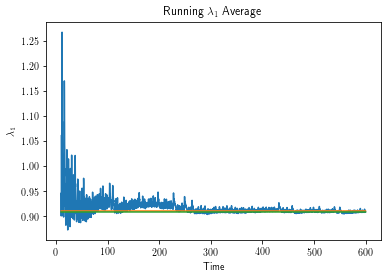

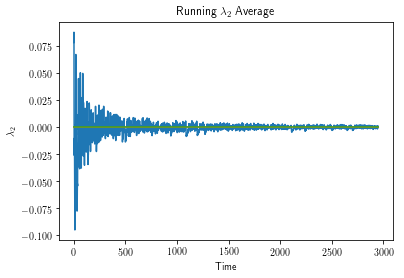

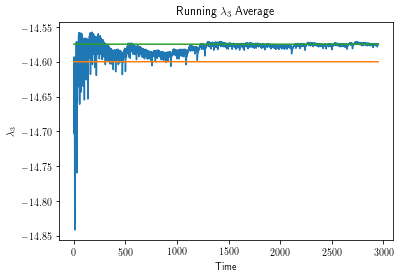

In [68]:
from matplotlib import rc
rc('text', usetex=True)

j = 50 # Controls time that plots will start from
length = LE[j:, 0].shape[0]
print(length)
time = tao * dt * (np.arange(length) + j)
print(time)

# First LE
plt.plot(time, LE[j:, 0])
plt.plot(time, 0.91 * np.ones(length)) # Literature value
plt.plot(time, means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_1$')
plt.title('Running $\lambda_1$ Average')
plt.savefig('First-LE.png')

# Second LE
plt.figure()
plt.plot(LE[j:, 1])
plt.plot(0 * np.ones(length)) # Literature value
plt.plot(means[1] * np.ones(length)) # Plotting mean value 
plt.xlabel('Time')
plt.ylabel('$\lambda_2$')
plt.title('Running $\lambda_2$ Average')
plt.savefig('Second-LE.png')

# Third LE
plt.figure()
plt.plot(LE[j:, 2])
plt.plot(-14.6 * np.ones(length)) # Literature value
plt.plot(means[2] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_3$')
plt.title('Running $\lambda_3$ Average')
plt.savefig('Third-LE.png')


## Zoomed in plots

In [64]:
j = int(L - 1.e4) # Controls time that plots will start from
length = len(np.arange(L)[j:])

# First LE
j = 4000 # Controls time that plots will start from
length = len(np.arange(L)[j:])

# First LE
plt.plot(np.arange(L)[j:], LE[j:, 0])
plt.plot(np.arange(L)[j:], 0.91 * np.ones(length)) # Literature value
plt.plot(np.arange(L)[j:], means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_1$')
plt.title('Running $\lambda_1$ Average')
plt.savefig('First-LE-Zoom.png')

# Second LE
plt.figure()
plt.plot(np.arange(L)[j:], LE[j:, 1])
plt.plot(np.arange(L)[j:], 0 * np.ones(length))
plt.plot(np.arange(L)[j:], means[1] * np.ones(length)) 
plt.xlabel('Time')
plt.ylabel('$\lambda_2$')
plt.title('Running $\lambda_2$ Average')
plt.savefig('Second-LE-Zoom.png')

# Third LE
plt.figure()
plt.plot(np.arange(L)[j:], LE[j:, 2])
plt.plot(np.arange(L)[j:], -14.6 * np.ones(length))
plt.plot(np.arange(L)[j:], means[2] * np.ones(length))
plt.xlabel('Time')
plt.ylabel('$\lambda_3$')
plt.title('Running $\lambda_3$ Average')
plt.savefig('Third-LE-Zoom.png')


NameError: name 'L' is not defined

## Statistics of FTLEs

### Mean

In [75]:
print(f'The averaged value of the FTLEs is {np.mean(FTLE, axis = 0)}.')

The averaged value of the FTLEs is [  3.79338287  -1.34309206 -43.04028888].


### Variance

In [76]:
print(f'Variance is {np.var(FTLE, axis = 0)}.\n\nSD is {np.std(FTLE, axis = 0)}.')

Variance is [116.91558767  56.85039174 125.0342908 ].

SD is [10.81275116  7.53991988 11.18187331].


### Histograms

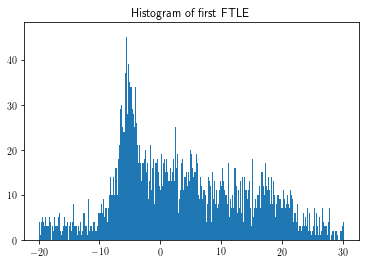

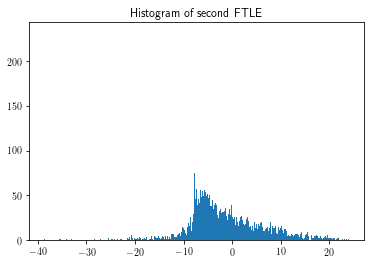

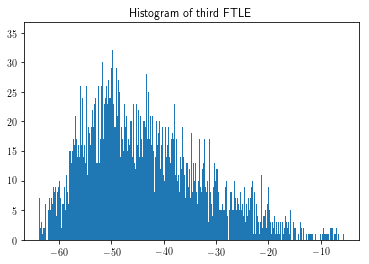

In [77]:
plt.hist(FTLE[:,0], bins = 1000)
plt.title("Histogram of first FTLE")
plt.savefig("FLTE1-Histogram.png")

plt.figure()
plt.hist(FTLE[:,1], bins = 1000)
plt.title("Histogram of second FTLE")
plt.savefig("FLTE2-Histogram.png")

plt.figure()
plt.hist(FTLE[:,2], bins = 1000)
plt.title("Histogram of third FTLE")
plt.savefig("FLTE3-Histogram.png")



### Pearson correlation coefficient

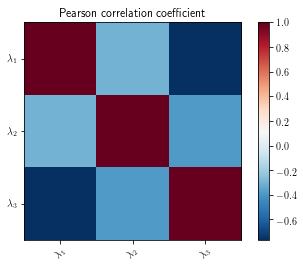

In [78]:
covm = np.corrcoef(FTLE.T) # Calculating Pearson correlation coefficient
#use np.cov for covariance

#Illustrating covariance matric as heatmap
fig, ax = plt.subplots() 
im = ax.imshow(covm, cmap='RdBu_r')

names = np.array(['$\lambda_1$', '$\lambda_2$', '$\lambda_3$']) # Labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Pearson correlation coefficient")
cbar = plt.colorbar(im)# Colorbar
plt.show()

### Kaplan Yorke Dimension

In [79]:
kydim = 2 + ((means[0] + means[1])/abs(means[2]))
print(f'Kaplan Yorke Dimension is {kydim}')

Kaplan Yorke Dimension is 2.0569301664138724


## Crude Monte Carlo Sampling